Engineer: Adeola Odunewu
Intern: FlipRobo LLC DS1123
Project: Loan Global Power Plant Classification

In [2]:
import joblib
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVR, SVC




from statsmodels.formula.api import ols
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, f_classif, RFE

from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

warnings.filterwarnings("ignore", message=".*deprecated.*")

In [3]:
# File paths for the CSV files
url = 'https://github.com/FlipRoboTechnologies/ML_-Datasets/raw/main/Census%20Income/Census%20Income.csv'

# Read CSV files into DataFrame objects
df = pd.read_csv(url)  

In [45]:
# Showing the first 5 column.
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
# Displaying Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [41]:
# Identifying missing values
missing_data = df.isnull().sum()
print(missing_data)

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64


In [36]:
# Showing the last five column 
df.tail()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [4]:
# Selecting columns with object dtype (typically strings)
cate_df = df.select_dtypes(include=['object'])

# Selecting columns with numeric dtypes (integers and floats)
numeric_df = df.select_dtypes(include=['int64', 'float64'])


In [25]:
# Displaying information about columns with categorical data types
cate_df.describe()

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
count,32560,32560,32560,32560,32560,32560,32560,32560,32560
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


In [26]:
# Displaying information about columns with numerical data types
numeric_df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


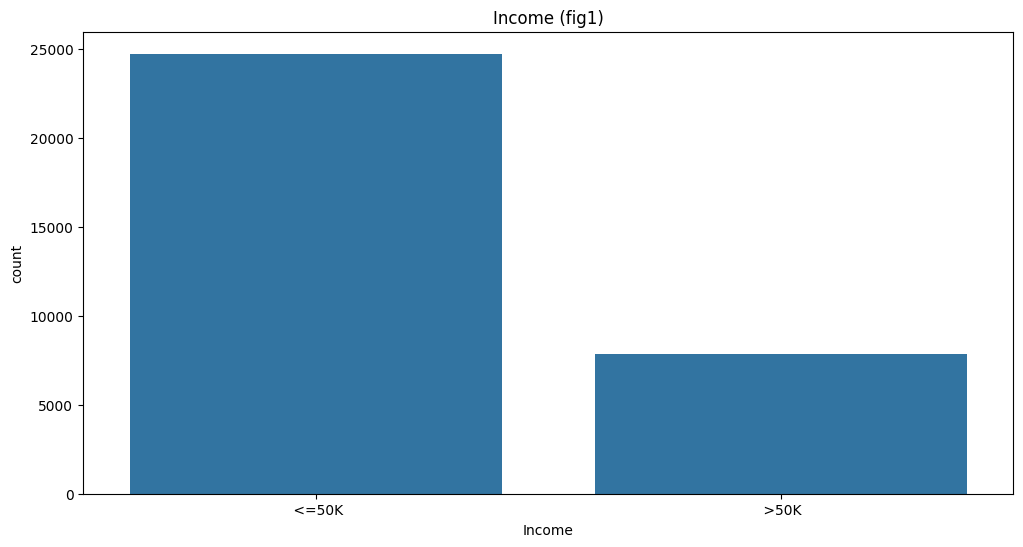

In [17]:
# Set the size of the figure
plt.figure(figsize=(8, 6))
# Create a histogram plot of the Income column from the DataFrame df
sns.countplot(data = df, x = 'Income')
plt.title('Income (fig1)')
plt.show()

In [5]:
df['Income']

0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
32555     <=50K
32556      >50K
32557     <=50K
32558     <=50K
32559      >50K
Name: Income, Length: 32560, dtype: object

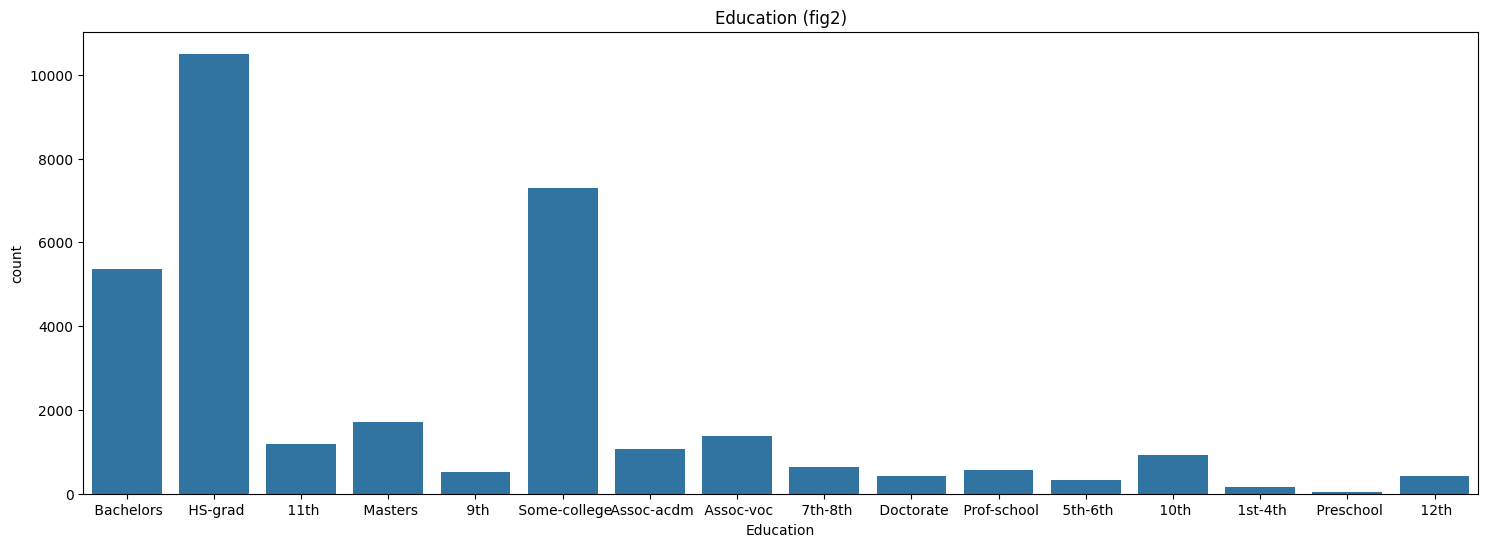

In [15]:
# Set the size of the figure
plt.figure(figsize=(18, 6))
# Create a histogram plot of the Occupation column from the DataFrame 'df'
sns.countplot(data = df, x = 'Education')
plt.title('Education (fig2)')
plt.show()

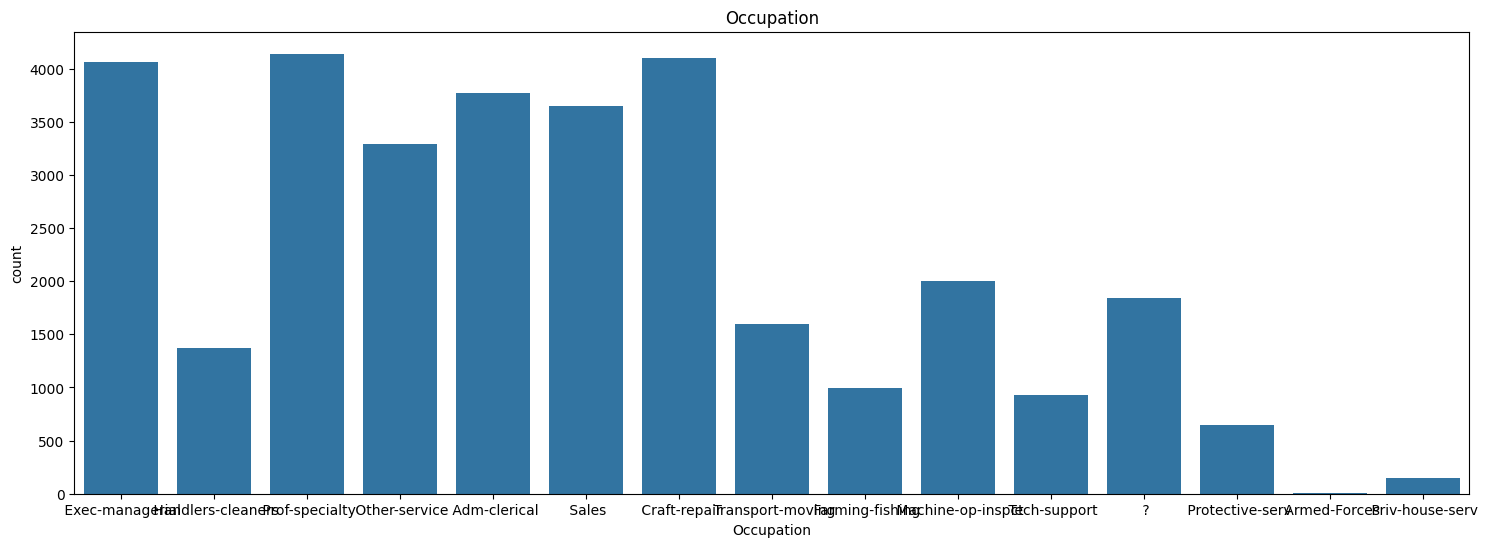

In [5]:
# Set the size of the figure
plt.figure(figsize=(18, 6))
# Create a histogram plot of the Occupation column from the DataFrame 'df'
sns.countplot(data = df, x = 'Occupation')
plt.title('Occupation')
plt.show()

People with incomes equal to or below 50k are more common compared to those whose income exceeds 50k.

In [32]:
# Generate descriptive statistics for the 'Income' column in the DataFrame 'df'
df['Income'].describe()

count      32560
unique         2
top        <=50K
freq       24719
Name: Income, dtype: object

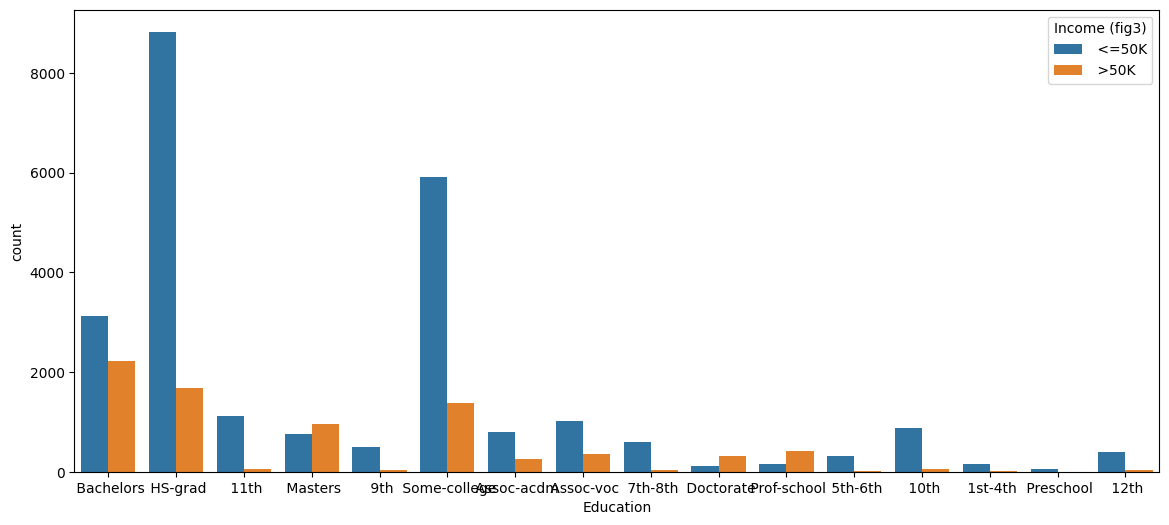

In [18]:
# Set the size of the figure
plt.figure(figsize=(14, 6))

# Create a count plot of 'Income' grouped by 'Education'
sns.countplot(data=df, x='Education', hue='Income')
plt.legend(title='Income (fig3)')
plt.show()


The graph above offers an overview of income distribution
 (Fig. 1). It depicts thata significant proportionfof  earners make below 50k annually 
(Fig. 2). among educational level), High School Graduates form the largest segmen).
(Fig. 3). The distribution illustrates that individuals with Bachelor's degrees, High School diplomas, and some college experience comprie smoslty of the sampled workforce.While, those holdin Bachelor's degrees,g Master's degrees,Doctoratess,andrPprofessiona(Prof-school)l qualifications consistently earn incomes surpassing 50k.

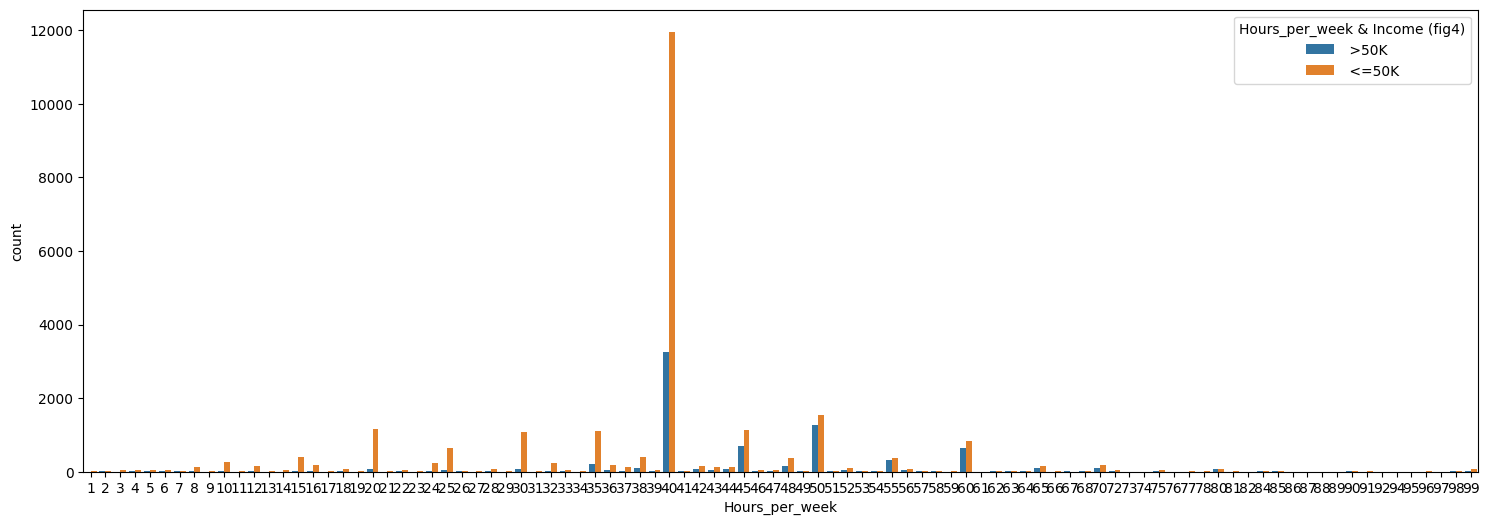

In [13]:
# Set the size of the figure
plt.figure(figsize=(18, 6))

# Create a count plot of Income grouped by Hours_per_week
sns.countplot(data=df, x='Hours_per_week', hue='Income')
plt.legend(title='Hours_per_week & Income (fig4)')
plt.show()

In Fig. 4, it is evident that the highest proportion of income earners making above 50k typically work an average of 40 hours per week.

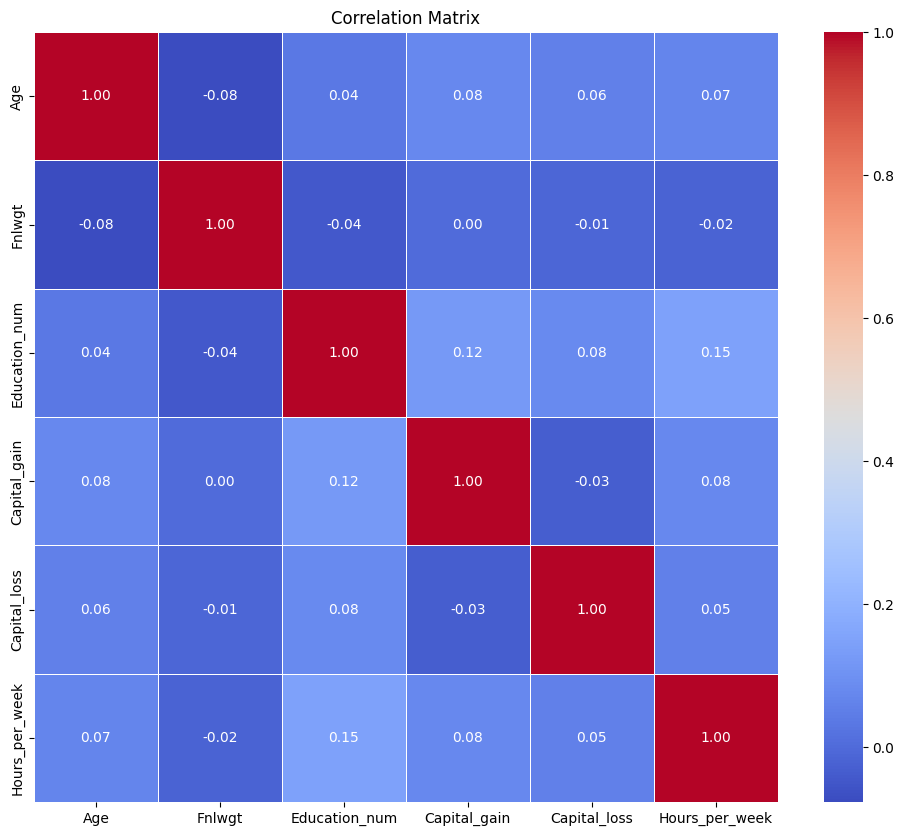

In [19]:
# Correlation Analysis for numeric_df is the DataFrame
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix including the target variable
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Evidence from the correlation analysis reveals that Education_num and Hours_per_week exhibit a positive relationship, with a correlation coefficient 
of 0.15. This implies that as the number of years of education increases, individuals tend to work more hours per week.

In contrast, Age and Fnlwgt demonstrate a weak negative relationship, with a correlation coefficient of -0.08. This suggests that as age increases,
the final weight tends to decrease slightly.

Regarding Fnlwgt and Capital_gain, their correlation coefficient is close to 0, indicating no significant linear relationship between them.

However, it's crucial to note that Education_num and Hours_per_week display signs of potential multicollinearity, as mentioned earlier. 
Further investigation into the extent of multicollinearity is warranted, especially if considering the use of linear regression. Remedial actions 
such as feature selection or regularization techniques may be necessary to address this issue effectively.


Feature Engineer

In [6]:
# Strip leading whitespace and convert Income column to numeric values
df['Income'] = df['Income'].str.strip().replace({'<=50K': 0, '>50K': 1})

In [7]:
# Convert object columns to categorical (factor) type
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns] = df[object_columns].astype('category')

The feature engineering process involves transforming raw data into a format that is suitable for machine learning algorithms, aiming to improve
model performance. In this code snippet, the 'Income' column is converted to numeric values, which is crucial for classification tasks where the
target variable needs to be numeric. Additionally, object-type columns are converted to categorical (factor) type, reducing memory usage and 
improving computational efficiency. By converting categorical variables to factors, the model can better understand the categorical nature of 
the data, which can lead to more accurate predictions.

Rows with outliers:
       Age   Workclass  Fnlwgt      Education  Education_num  \
9       37     Private  280464   Some-college             10   
22      43     Private  117037           11th              7   
27      39     Private  367260        HS-grad              9   
31      45     Private  386940      Bachelors             13   
36      19     Private  544091        HS-grad              9   
...    ...         ...     ...            ...            ...   
32493   82           ?  403910        HS-grad              9   
32510   25   Local-gov  514716      Bachelors             13   
32517   57   Local-gov  110417        HS-grad              9   
32524   81           ?  120478      Assoc-voc             11   
32530   30           ?   33811      Bachelors             13   

            Marital_status         Occupation    Relationship  \
9       Married-civ-spouse    Exec-managerial         Husband   
22      Married-civ-spouse   Transport-moving         Husband   
27              

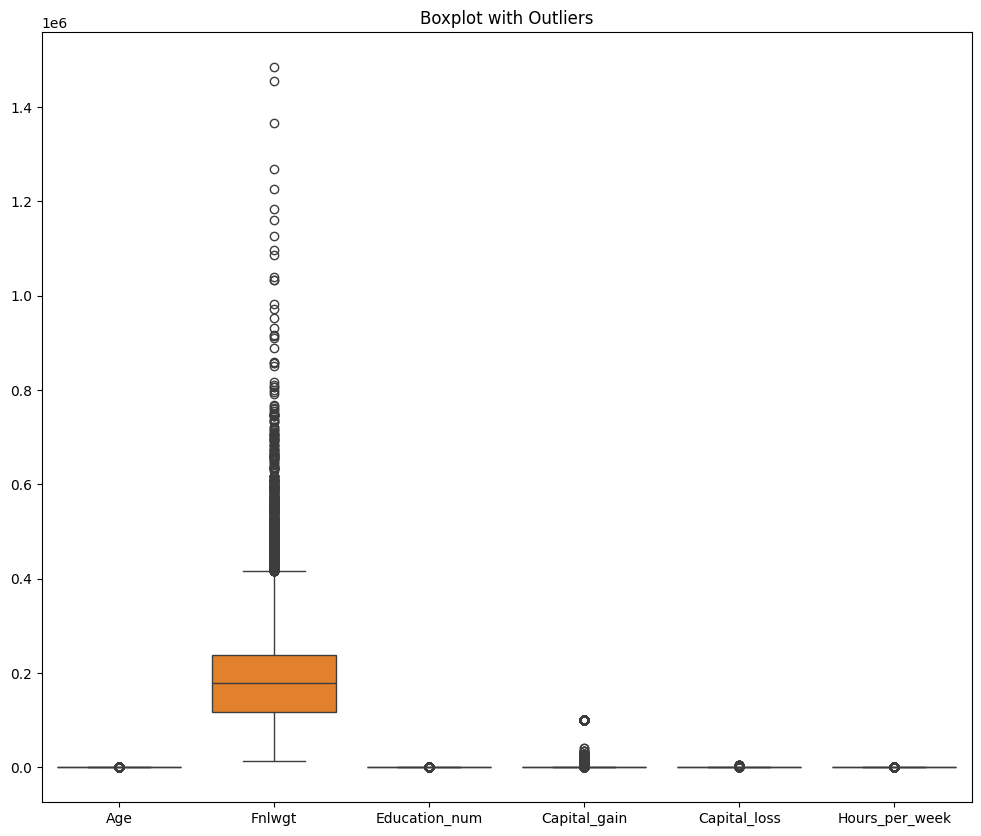

In [29]:
# Identifying Outliers

# Calculate z-scores for each data point
z_scores = ((numeric_df - numeric_df.mean()) / numeric_df.std()).abs()

# Define threshold for outliers (if z-score greater than 3)
outlier_threshold = 3

# Identify outliers using the z-score method
outlier_conditions = (z_scores > outlier_threshold)

# Display rows containing outliers
outliers = df[outlier_conditions.any(axis=1)]
print("Rows with outliers:")
print(outliers)

# Visualize the outliers using a boxplot
plt.figure(figsize=(12, 10))  
sns.boxplot(data=numeric_df) 
plt.title("Boxplot with Outliers")
plt.show()


Based on the output, the z-score analysis identified potential outliers in several columns of the dataset:
Education_num (Education Level): No obvious outliers were identified in the Education_num column.

Capital_gain: Row 7 exhibited a significant capital gain of 14084, which stands out compared to the rest of the data and could be considered an outlier.

Hours_per_week: Row 9 displayed an exceptionally high number of hours worked per week (80), suggesting it could be an outlier.

Fnlwgt (Final Weight): Rows such as  9, 22, 31... contained Fnlwgt values that could be considered outliers.
I will use log transformation on Fnlwgt, Capital_gain.

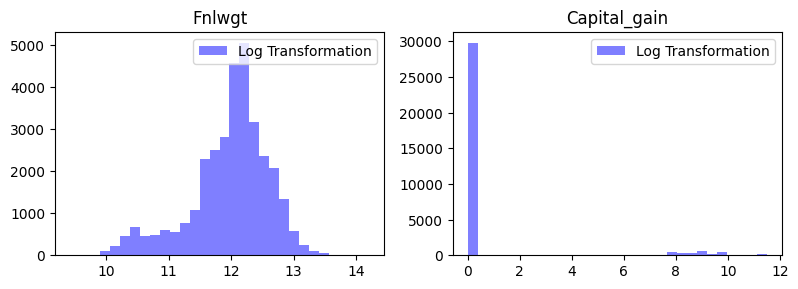

In [8]:
# Handling outliers
# Step 1: Identify Variables with Outliers
outlier_vars = ['Fnlwgt', 'Capital_gain']

# Step 2: Apply Logarithmic Transformation
# Logarithmic Transformation
log_transformed_vars = df[outlier_vars].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0) issues

# Replace the original columns with the transformed columns
df[outlier_vars] = log_transformed_vars  

# Visualize the transformed data
plt.figure(figsize=(12, 8))
for i, col in enumerate(outlier_vars):
    plt.subplot(3, 3, i+1)
    plt.hist(log_transformed_vars[col], bins=30, alpha=0.5, color='blue', label='Log Transformation')
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()


In [12]:
# PCA Analysis
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Transform the data into the principal components
pca_data = pca.transform(scaled_data)

# Extracting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# df_columns is a list of column names in the df1 DataFrame
df_columns = numeric_df.columns.tolist()

# Create a DataFrame to store the variable loadings for each principal component
loadings_df = pd.DataFrame(pca.components_, columns=df_columns)

# Print the variable loadings for each principal component
for i in range(loadings_df.shape[0]):
    print(f"Principal Component {i+1} Loadings:")
    print(loadings_df.iloc[i].sort_values(ascending=False))
    print()
# Create a DataFrame to examine the principal components
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Visualize the explained variance ratio
print("Explained Variance Ratio:", explained_variance_ratio)


Principal Component 1 Loadings:
Income            0.624645
Education_num     0.421093
Capital_gain      0.403311
Hours_per_week    0.337711
Age               0.335293
Capital_loss      0.198324
Fnlwgt           -0.063535
Name: 0, dtype: float64

Principal Component 2 Loadings:
Capital_loss      0.700799
Education_num     0.246835
Hours_per_week    0.222639
Fnlwgt            0.021274
Income            0.010090
Age              -0.289431
Capital_gain     -0.560412
Name: 1, dtype: float64

Principal Component 3 Loadings:
Age               0.577483
Capital_loss      0.320843
Income           -0.026775
Capital_gain     -0.158819
Education_num    -0.280388
Hours_per_week   -0.288299
Fnlwgt           -0.613106
Name: 2, dtype: float64

Principal Component 4 Loadings:
Fnlwgt            0.756723
Age               0.364283
Capital_loss      0.335820
Income            0.099186
Capital_gain      0.030436
Hours_per_week   -0.161390
Education_num    -0.380896
Name: 3, dtype: float64

Principal Compon

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_df.columns

# Calculate VIF for each predictor variable
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]

# Print the VIF DataFrame
print(vif_data)

         Variable        VIF
0             Age   7.246276
1          Fnlwgt   3.683279
2   Education_num  10.983337
3    Capital_gain   1.032984
4    Capital_loss   1.056818
5  Hours_per_week   9.757850


As previously noted, Education_num and Hours_per_week exhibit high VIF values, suggesting possible multicollinearity issues. To address this, it's crucial to apply log transformations to these variables. This approach aims to normalize their distributions and stabilize variance, potentially mitigating multicollinearity concerns.

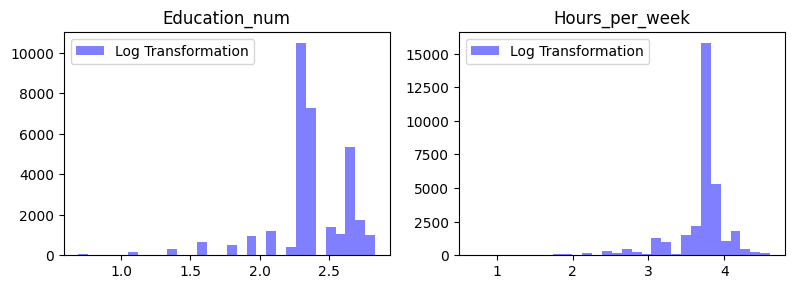

In [9]:
# Handling Multicollinearity Concerns
# Identify Variables with Multicollinearity: Step 1

concerns_vars = ['Education_num', 'Hours_per_week']

# Apply Logarithmic Transformation: Step 2
# Logarithmic Transformation
log_transformed_vars = df[concerns_vars].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0) issues

# Replace the original columns with the transformed columns
df[concerns_vars] = log_transformed_vars  

# Visualize the transformed data
plt.figure(figsize=(12, 8))
for i, col in enumerate(concerns_vars):
    plt.subplot(3, 3, i+1)
    plt.hist(log_transformed_vars[col], bins=30, alpha=0.5, color='blue', label='Log Transformation')
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()

In [17]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [23]:

# Set the random seed
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']]  # Features (excluding categorical columns)
X_categorical = pd.get_dummies(df[['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country']])  # One-hot encode categorical columns
X = pd.concat([X, X_categorical], axis=1)  # Combine numerical and encoded categorical features
y = df['Income']

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Initialize RandomForestRegressor
random_forest = RandomForestRegressor()
# Fit the model
model = random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top N important features
print("Top 10 Important Features:")
print(feature_importance_df.head(10))
print("=" * 50)

# Make predictions on test set
y_pred = random_forest.predict(X_test)

# Evaluate the regressor
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print results
print("Regressor: RandomForestRegressor")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r_squared:.4f}")
print("=" * 50)



Top 10 Important Features:
                               Feature  Importance
33  Marital_status_ Married-civ-spouse    0.198572
1                               Fnlwgt    0.171531
2                        Education_num    0.114135
0                                  Age    0.112415
3                         Capital_gain    0.103103
5                       Hours_per_week    0.063909
4                         Capital_loss    0.038671
42         Occupation_ Exec-managerial    0.011769
10                  Workclass_ Private    0.009189
12         Workclass_ Self-emp-not-inc    0.009001
Regressor: RandomForestRegressor
Mean Squared Error: 0.0980
R-squared: 0.4580


In the modelling process, correlation analysis uncovered valuable insights regarding variable relationships.  

Subsequent z-score analysis revealed potential outliers across various dataset columns, These outliers have the potential to impact model performance. 
To address this concern, a log transformation was applied.
Furthermore, Education_num and Hours_per_week exhibited high VIF values, indicating potential multicollinearity issues. To address this concern, 
a log transformation was applied to both variables to normalize their distributions and stabilize the variance.

Additionally, Principal Component Analysis (PCA) identified key loadings, highlighting influential variables for income prediction. 
In tandem, Random Forest (RF) analysis pinpointed significant predictors among the feature set for income prediction.

These steps underscore the rationale for picking these variables and emphasize the importance of feature selection and feature importance analysis
to ensure the robustness of the model.

In [10]:
# Set the random seed
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']]  # Features (excluding categorical columns)
X_categorical = pd.get_dummies(df[['Workclass', 'Education', 'Marital_status', 'Occupation']])  # One-hot encode categorical columns
X = pd.concat([X, X_categorical], axis=1)  # Combine numerical and encoded categorical features
y = df['Income']

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)


In [11]:
# Checking for imbalance in the datasets.)
y.value_counts()

Income
0    24719
1     7841
Name: count, dtype: int64

In [12]:
# Initialize SMOTE ( to address the class imbalance in the datasets.)
sm = SMOTE()

# The implementation of the fit_resample 
X,y = sm.fit_resample(X,y)

# Create a DataFrame to see the distribution of classes in the target vector y
data = pd.concat([X, y], axis=1)
class_distribution = data[y.name].value_counts()

print(class_distribution)

Income
0    24719
1    24719
Name: count, dtype: int64


In [13]:
# Set the random seed
np.random.seed(123)

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize classifiers
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
logistic_regression = LogisticRegression()
support_vector_machine = SVC()
xgboost_classifier = xgb.XGBClassifier(reg_alpha=0.1, reg_lambda=0.1)  # Set regularization parameters
classifiers = [random_forest, gradient_boosting, logistic_regression, support_vector_machine, xgboost_classifier]

# Perform k-fold cross-validation for each classifier
for clf in classifiers:
    # Perform 10-fold cross-validation
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    
    # Print the results
    print(f"Classifier: {clf.__class__.__name__}")
    print(f"Accuracy: {scores.mean():.4f} +/- {scores.std():.4f}")
    print("="*50)


Classifier: RandomForestClassifier
Accuracy: 0.9001 +/- 0.0481
Classifier: GradientBoostingClassifier
Accuracy: 0.8681 +/- 0.0308
Classifier: LogisticRegression
Accuracy: 0.8288 +/- 0.0245
Classifier: SVC
Accuracy: 0.6792 +/- 0.0080
Classifier: XGBClassifier
Accuracy: 0.8970 +/- 0.0519


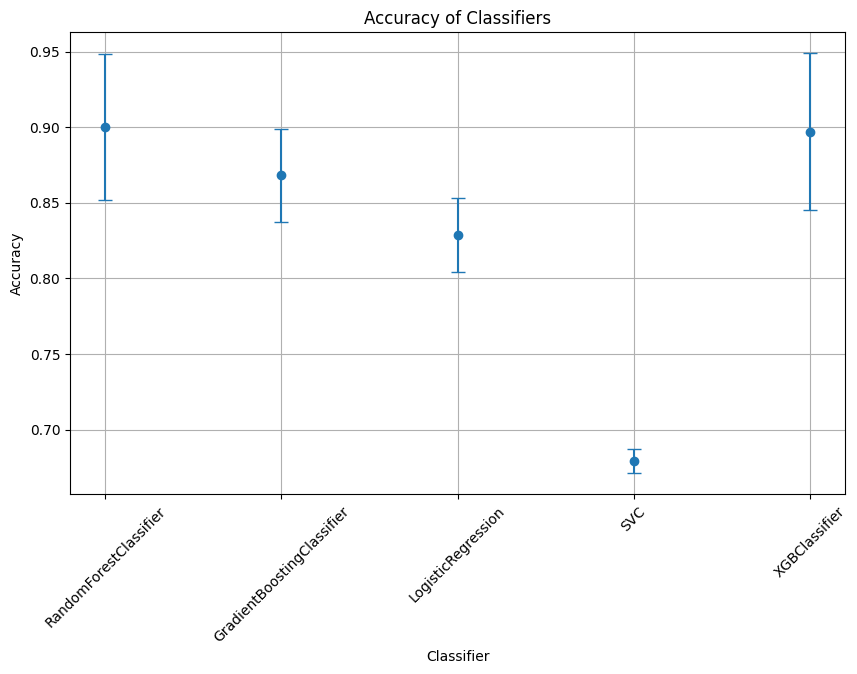

In [17]:
# Set the random seed
np.random.seed(123)

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize classifiers
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
logistic_regression = LogisticRegression()
support_vector_machine = SVC()
xgboost_classifier = xgb.XGBClassifier(reg_alpha=0.1, reg_lambda=0.1)  # Set regularization parameters
classifiers = [random_forest, gradient_boosting, logistic_regression, support_vector_machine, xgboost_classifier]

# Initialize lists to store results
classifier_names = [clf.__class__.__name__ for clf in classifiers]
mean_scores = []
std_scores = []

# Perform k-fold cross-validation for each classifier
for clf in classifiers:
    # Perform 10-fold cross-validation
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    
    # Store mean and standard deviation of scores
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(classifier_names, mean_scores, yerr=std_scores, fmt='o', capsize=5)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Classifiers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

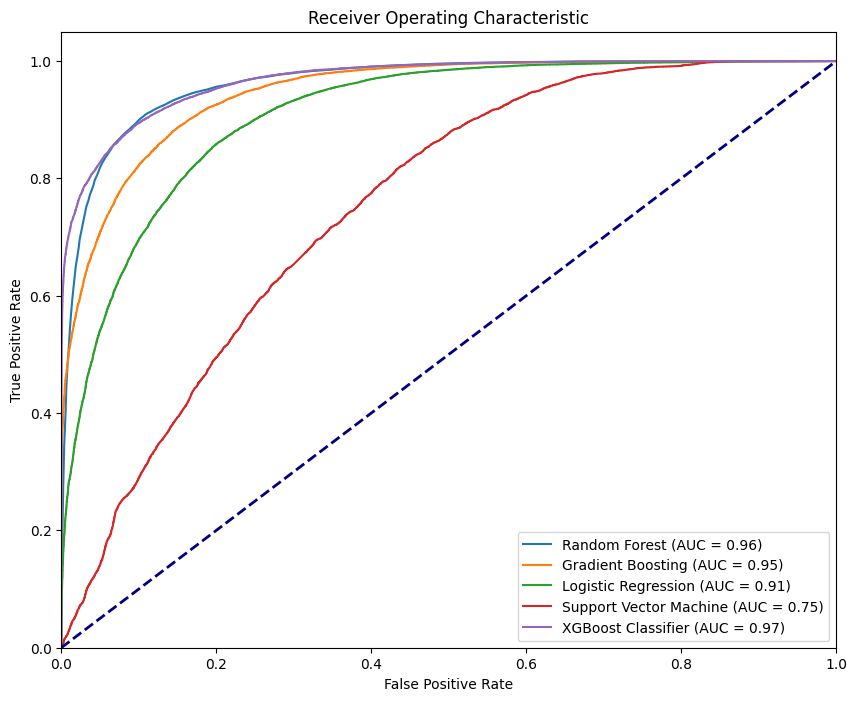

In [20]:
# Set the random seed
np.random.seed(123)

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize classifiers
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
logistic_regression = LogisticRegression()
support_vector_machine = SVC(probability=True)  # SVC needs probability=True for predict_proba
xgboost_classifier = xgb.XGBClassifier(reg_alpha=0.1, reg_lambda=0.1)  # Set regularization parameters

classifiers = [
    ("Random Forest", random_forest),
    ("Gradient Boosting", gradient_boosting),
    ("Logistic Regression", logistic_regression),
    ("Support Vector Machine", support_vector_machine),
    ("XGBoost Classifier", xgboost_classifier)
]

plt.figure(figsize=(10, 8))

# Perform k-fold cross-validation for each classifier
for name, clf in classifiers:
    y_prob = cross_val_predict(clf, X, y, cv=10, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot attributes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Set the random seed
np.random.seed(123)

# Initialize XGBoost classifier
xgboost_classifier = xgb.XGBClassifier()

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 4, 5],  # Maximum depth of the trees
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'subsample': [0.7, 0.8, 0.9],  # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgboost_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model
best_xgboost_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_xgboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")


Best parameters found:
{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
Accuracy on Test Set: 0.8765


In [22]:
# Save the trained XGBoost model
joblib.dump(best_xgboost_model, 'Census_model.joblib')

['Census_model.joblib']

In summary, the modeling process involved correlation analysis to unveil variable relationships, followed by z-score analysis to detect potential 
outliers with the potential to impact model performance. Log transformations were applied to address these outliers and normalize variable distributions,
particularly for Education_num and Hours_per_week, which exhibited high VIF values indicating multicollinearity issues. Additionally, Principal 
Component Analysis (PCA) and Random Forest (RF) analysis identified influential variables and significant predictors, respectively, underlining the
importance of feature selection and analysis for ensuring model robustness. The best parameters for the model were determined, resulting in an accuracy
of 0.8765 on the test set, and the finalized model was saved for future use.